# Practica 5 (Regresión lineal regularizada: sesgo y varianza)
### Aprendizaje automático y big data
##### _Alberto García Doménech - Pablo Daurell Marina_    
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

El objetivo de esta práctica es comprobar los efectos del sesgo (bias) y la varianza. Para ello entrenaremos a un modelo de regresión lineal regularizada.   

Usaremos un dataset que representa datos históricos del agua que ha derramado una presa en base a los cambios del nivel del agua.

In [2]:
def read_data(file):
    # Cargamos los datos
    data = loadmat(file)

    # Datos de entrenamiento
    X = data['X']
    y = data['y']
    # Datos de test
    Xtest = data['Xtest']
    ytest = data['ytest']
    # Datos de validacion cruzada
    Xval = data['Xval']
    yval = data['yval']
    
    return X, y, Xtest, ytest, Xval, yval

In [3]:
X, y, Xtest, ytest, Xval, yval = read_data('ex5data1.mat')

X = np.hstack([np.ones([np.shape(X)[0], 1]), X])
Xtest = np.hstack([np.ones([np.shape(Xtest)[0], 1]), Xtest])
Xval = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])

## Regresión lineal regularizada

Vamos a implementar las funciones para calcular el coste y el gradiente regularizados de nuestro modelo de regresión lineal:

In [4]:
def cost(Theta, X, Y, reg):
    m = X.shape[0]  
    H = np.dot(X, Theta)
    aux = (1 / (2*m)) * np.sum((H - Y.ravel())**2)
    regul = (reg / (2*m)) * np.sum(Theta[1:]**2)
    cost = (aux + regul)
    return cost

# def cost(Theta, X, Y, reg):
#     m = X.shape[0]
#     H = np.matmul(X, Theta)
#     aux = H - Y.ravel()
#     aux = np.matmul(aux.T, aux)
#     aux = (1 / (2 * m)) * aux
    
#     regul = np.matmul(theta[1:], theta[1:])
#     regul = (reg / (2 * m)) * regul
    
    return (aux + regul)

def gradient(Theta, X, Y, reg):
    H = np.dot(X, Theta)
    grad = np.dot(X.T, H - Y.ravel()) / len(X)
    regul = (reg/len(X)) * Theta[1:]
    grad[1:] += regul
    return grad

In [5]:
reg = 1
theta = np.ones(np.shape(X)[1])
print("Coste: ", cost(theta, X, y, reg))
print("Gradiente: ", gradient(theta, X, y, reg))

Coste:  303.9931922202643
Gradiente:  [-15.30301567 598.25074417]



Hacemos uso de la funcion de scipy, ```minimize```, para encontrar un valor de Theta que minimize el coste: 

In [6]:
import scipy.optimize as opt

theta = np.zeros(np.shape(X)[1])
reg = 0

fmin = opt.minimize(fun=cost, x0=theta, args=(X, y, reg), jac=gradient)
theta_opt = fmin.x

print("Theta optima: ", theta_opt, ", Coste: ", cost(theta_opt, X, y, reg))

Theta optima:  [13.08790351  0.36777923] , Coste:  22.373906495108915


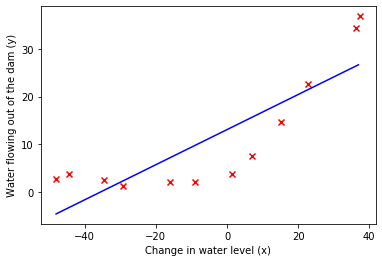

In [7]:
plt.scatter(X[:, 1:], y, color='red', marker='x')
x_arr = np.arange(min(X.ravel()), max(X.ravel()))
y_arr = []
for x in x_arr:
    x = list(x.ravel())
    x.insert(0, 1)
    y_arr.append(np.dot(x, theta_opt))
    
plt.plot(x_arr, y_arr, color='blue')    
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.show()

> Vemos que la predicción resultante de entrenar a nuestro modelo es muy poco precisa ya que tenemos pocos datos y además, tal y como están distribuidos, una recta es demasiado simple para ajustarse bien.

## Curvas de aprendizaje

Vamos a pintar las curvas de aprendizaje resultantes de entrenar al modelo con distintos subconjuntos de los ejemplos de entrenamiento, para ver como varía el coste.
Una vez entrenado también vamos a comprobar la variación del coste en el conjunto de datos de validación cruzada.

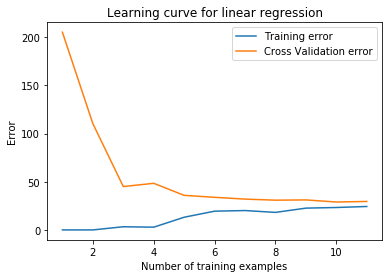

In [8]:
training_x = []
training_y = []
crossval_x = []
crossval_y = []

theta = np.zeros((X.shape[1], 1))
reg = 0

for i in range(1, X.shape[0]):
    training_x.append(i)
    crossval_x.append(i)
    theta_opt = opt.minimize(fun=cost, args=(X[0:i], y[0:i], reg), x0=theta, jac=gradient).x
    training_y.append(cost(theta_opt, X[0:i], y[0:i], reg))
    crossval_y.append(cost(theta_opt, Xval, yval, reg))

plt.plot(training_x, training_y, label='Training error')
plt.plot(crossval_x, crossval_y, label='Cross Validation error')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.legend()
plt.show()

> Vemos que a medida que aumentan el numero de ejemplos de entrenamiento, el error del conjunto de entrenamiento y el de validación cruzada se aproximan. Esto indica que se está produciendo un aprendizaje sesgado.

## Regresión polinomial

Para corregir el sesgo de nuestro modelo vamos a crear un polinimio a partir de los datos de entrada para aumentar la cantidad de atributos de los ejemplos:

In [9]:
def polynomize(X, p):
    for i in range(p+1):
        if i < 2:
            pass
        else:
            aux = np.power(X[:, 0], i)
            aux = aux.reshape((len(X), 1))
            X = np.append(X, aux, axis=1)
    return X

def normalize(X):
    '''Normaliza los datos de la matriz X
    restandoles su media y dividiendolos por la desviacion estandar'''
    mu = np.mean(X, axis=0)
    X_mean = X - mu
    sigma = np.std(X, axis=0)
    X_norm = X_mean / sigma
    return X_norm, mu, sigma

In [10]:
# Cargamos los datos
X,  y, Xtest, ytest, Xval, yval = read_data('ex5data1.mat')

# Normalizamos X, le añadimos factores polinomiales y el atributo de bias (columna de 1s)
degree = 8

X_poly = polynomize(X, degree)
X_norm, mu, sigma = normalize(X_poly)
X_norm = np.hstack([np.ones([np.shape(X)[0], 1]), X_norm])

# Entrenamos al modelo con los nuevos datos
theta = np.zeros(X_norm.shape[1])
reg = 0
theta_opt = opt.minimize(fun=cost, x0=theta, args=(X_norm, y, reg), jac=gradient).x
cost(theta_opt, X_norm, y, reg)

0.028890520913311055

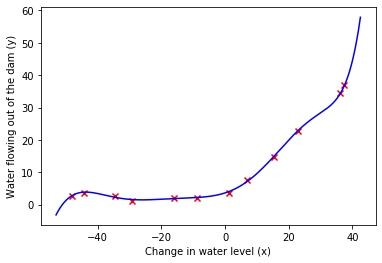

In [11]:
plt.scatter(X, y, color='red', marker='x')
x_arr = np.arange(min(X.ravel())-5, max(X.ravel())+5, 0.05)
y_arr = []

x_aux = np.reshape(x_arr,(-1, 1))
x_aux = polynomize(x_aux, degree)
x_aux = (x_aux - mu) / sigma
x_aux = np.hstack([np.ones([np.shape(x_aux)[0], 1]), x_aux])

y_arr = np.dot(x_aux, theta_opt)
    
plt.plot(x_arr, y_arr, color='blue')    
plt.xlabel("Change in water level (x)")
plt.ylabel("Water flowing out of the dam (y)")
plt.show()

> Vemos que tras polinomizar los datos de entrada las predicciones del modelo se ajustan mucho mejor a estos.   
Sin embargo, quizas se están ajustando demasiado a los datos de entrenamiento y tengamos sobreaprendizaje (Nótese que para esta prueba no hemos usado regularización)

**Curvas de aprendizaje:**    
Volvemos a pintar las curvas de aprendizaje, esta vez con los nuevos datos de entrada procesados y los datos de validación cruzada.   
Probaremos distintos valores de regularización.

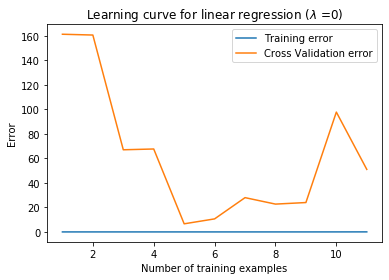

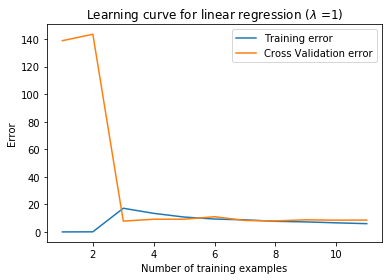

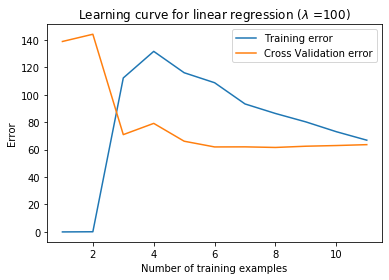

In [12]:
# Cargamos los datos
X,  y, Xtest, ytest, Xval, yval = read_data('ex5data1.mat')

# Normalizamos y polinomizamos los datos de entrenamiento
degree = 8
X = polynomize(X, degree)
X, mu, sigma = normalize(X)
X = np.hstack([np.ones([np.shape(X)[0], 1]), X])

# Normalizamos y polinomizamos los datos de validacion cruzada
Xval = polynomize(Xval ,degree)
Xval = (Xval - mu) / sigma
Xval = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])

# Pintamos las curvas de aprendizaje (con reg = 0, 1 y 100)
for reg in (0,1, 100):
    training_x = []
    training_y = []
    crossval_x = []
    crossval_y = []

    theta = np.zeros((X.shape[1], 1))

    for i in range(1, X.shape[0]):
        training_x.append(i)
        crossval_x.append(i)
        theta_opt = opt.minimize(fun=cost, args=(X[0:i], y[0:i], reg), x0=theta, jac=gradient).x
        training_y.append(cost(theta_opt, X[0:i], y[0:i], reg))
        crossval_y.append(cost(theta_opt, Xval, yval, reg))

    plt.plot(training_x, training_y, label='Training error')
    plt.plot(crossval_x, crossval_y, label='Cross Validation error')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Learning curve for linear regression ($\lambda$ ={})'.format(reg))
    plt.legend()
    plt.show()

> Observamos que variar el término de regularización nos permite variar el ajuste respecto a los ejemplos de entrenamiento

### Selección del parámetro $\lambda$

- Observamos la evolución del error en función del término de regularización:

0 0.02889051582840465 54.09074608940052
0.001 0.16941795914342211 9.393097996738772
0.003 0.2431714917701124 15.965673289104211
0.01 0.3712825524350588 17.23651933175236
0.03 0.6367028573713025 13.422034258065198
0.1 1.3605722535440756 8.453199253141769
0.3 2.9176493464166895 5.931955292685835
1 6.830463317365309 7.047224894118273
3 14.937645805916837 9.782200058050263
10 31.878154019264112 18.63391103496646


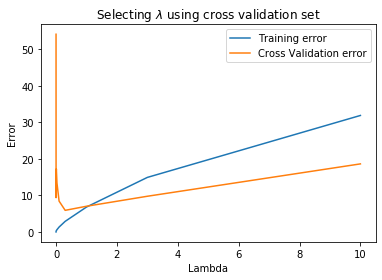

In [13]:
training_x = []
training_y = []
crossval_x = []
crossval_y = []

degree = 8

for reg in (0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10):
    X,  y, Xtest, ytest, Xval, yval = read_data('ex5data1.mat')
    
    X = polynomize(X, degree)
    X, mu, sigma = normalize(X)
    X = np.hstack([np.ones([np.shape(X)[0], 1]), X])

    Xval = polynomize(Xval ,degree)
    Xval = (Xval - mu) / sigma
    Xval = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])
    
    training_x.append(reg)
    crossval_x.append(reg)
    
    theta = np.zeros((X.shape[1], 1))
    theta_opt = opt.minimize(fun=cost, args=(X, y, reg), x0=theta).x
    
    print(reg, cost(theta_opt, X, y, reg), cost(theta_opt, Xval, yval, reg))
    training_y.append(cost(theta_opt, X, y, reg))
    crossval_y.append(cost(theta_opt, Xval, yval, reg))

plt.plot(training_x, training_y, label='Training error')
plt.plot(crossval_x, crossval_y, label='Cross Validation error')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.title('Selecting $\lambda$ using cross validation set')
plt.legend()
plt.show()

> El mejor resultado lo obtenemos con $\lambda$ = 0.3

- Finalmente, para comprobar si $\lambda$ = 0.3 nos sirve, calculamos el error sobre el conjunto de test:

In [23]:
# Cargamos los datos
X,  y, Xtest, ytest, Xval, yval = read_data('ex5data1.mat')

degree = 8
X = polynomize(X, degree)
X, mu, sigma = normalize(X)
X = np.hstack([np.ones([np.shape(X)[0], 1]), X])

# Normalizamos y polinomizamos los datos de test
Xtest = polynomize(Xtest ,degree)
Xtest = (Xtest - mu) / sigma
Xtest = np.hstack([np.ones([np.shape(Xtest)[0], 1]), Xtest])

# Entrenamos al modelo con reg = 3
theta = np.zeros(X.shape[1])
reg = 0.3
theta_opt = opt.minimize(fun=cost, x0=theta, args=(X, y, reg)).x


print('Cost: ', cost(theta_opt, X, y, reg))
print('Cost: ', cost(theta_opt, Xtest, ytest, reg))

Cost:  2.9176493464166895
Cost:  6.492525845365467
